In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset
from sklearn.metrics import balanced_accuracy_score

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
from torch.nn.utils import weight_norm
import matplotlib.pyplot as plt
import time
import os,sys
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.cuda.is_available()

PyTorch Version:  1.9.1
Torchvision Version:  0.10.1


True

In [3]:
from collections import defaultdict
def double_conv3d(in_channels, out_channels):
    return nn.Sequential(
        weight_norm(nn.Conv3d(in_channels, out_channels, 3, padding=1)),
        nn.ReLU(inplace=True),
#         weight_norm(nn.Conv3d(out_channels, out_channels, 3, padding=1)),
#         nn.ReLU(inplace=True)
    )   

def double_conv2d(in_channels, out_channels):
    return nn.Sequential(
        weight_norm(nn.Conv2d(in_channels, out_channels, 3, padding=1)),
        nn.ReLU(inplace=True),
#         weight_norm(nn.Conv3d(out_channels, out_channels, 3, padding=1)),
#         nn.ReLU(inplace=True)
    ) 


class UNet2D3D(nn.Module):

    def __init__(self, n_class, in_channels,dropout=0.1):
        super().__init__()
#       3d conv          
        self.dconv_down13d = double_conv3d(in_channels, 32)
        self.dconv_down23d = double_conv3d(32, 64)
        self.dconv_down33d = double_conv3d(64, 128)
        self.dconv_down43d = double_conv3d(128, 256)
#         self.dconv_down5 = double_conv3d(128, 256)

        self.maxpool3d = nn.MaxPool3d(2)
        self.upsample3d = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)  
#         self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)        
        
#         self.dconv_up4 = double_conv3d(128 + 256, 128)
        self.dconv_up33d = double_conv3d(128+ 256, 128)
        self.dconv_up23d = double_conv3d(64 + 128, 64)
        self.dconv_up13d = double_conv3d(32 + 64, 32)
        
        self.conv_last3d = nn.Conv3d(32, in_channels, 1)
        
        self.fc13d = nn.Linear(2048,1024)
        
#       2d conv
        self.dconv_down12d = double_conv2d(in_channels, 64)
        self.dconv_down22d = double_conv2d(64, 128)
        self.dconv_down32d = double_conv2d(128, 256)
        self.dconv_down42d = double_conv2d(256, 512)
        self.dconv_down52d = double_conv2d(512, 1024)

        self.maxpool2d = nn.MaxPool2d(2)
        self.upsample2d = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up42d = double_conv2d(512 + 1024, 512)
        self.dconv_up32d = double_conv2d(256 + 512, 256)
        self.dconv_up22d = double_conv2d(128 + 256, 128)
        self.dconv_up12d = double_conv2d(64 + 128, 64)
        
        self.conv_last2d = nn.Conv2d(64, in_channels, 1)
        
        self.fc12d = nn.Linear(25600,1024)
        
#       shared functions  
        self.bn_fc1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(2048,2048)
        self.out = nn.Linear(2048, n_class)
        self.relu = nn.ReLU()
#         self.signmoid = nn.Sigmoid()
#         self.init_weights()
        
#     def init_weights(self):
#         self.dconv_down1.weight.data.normal_(0, 0.01)
#         self.dconv_down2.weight.data.normal_(0, 0.01)
#         self.dconv_down3.weight.data.normal_(0, 0.01)
#         self.dconv_down4.weight.data.normal_(0, 0.01)
#         self.dconv_up3.weight.data.normal_(0, 0.01)
#         self.dconv_up2.weight.data.normal_(0, 0.01)
#         self.dconv_up1.weight.data.normal_(0, 0.01)
#         self.conv_last.weight.data.normal_(0, 0.01)
        
    def forward(self, x2d, x3d):
#       3d contraction path  
        conv13d = self.dconv_down13d(x3d)
        x3d = self.maxpool3d(conv13d)

        conv23d = self.dconv_down23d(x3d)
        x3d = self.maxpool3d(conv23d)
        
        conv33d = self.dconv_down33d(x3d)
        x3d = self.maxpool3d(conv33d)   
        
        conv43d = self.dconv_down43d(x3d)
        
#       2d contraction path  
        conv12d = self.dconv_down12d(x2d)
        x2d = self.maxpool2d(conv12d)

        conv22d = self.dconv_down22d(x2d)
        x2d = self.maxpool2d(conv22d)
        
        conv32d = self.dconv_down32d(x2d)
        x2d = self.maxpool2d(conv32d)   
        
        conv42d = self.dconv_down42d(x2d)
        x2d = self.maxpool2d(conv42d) 
    
        x2d = self.dconv_down52d(x2d) 
        

        #Classifier
#       2d flatten
        flatten2d = x2d.view(x2d.size(0),-1)
        y2d = self.fc12d(flatten2d)
    
#       3d flatten
        x13d = self.maxpool3d(conv43d) 
#         print('x1:',x1.size())
        flatten3d = x13d.view(x13d.size(0),-1)
#         print('fc:',flatten.size())
        y3d = self.fc13d(flatten3d)
    
#       combine flatten features
        y = torch.cat([y2d, y3d], dim=1)
        y = self.relu(y)
        y= self.fc2(y)
        y = self.bn_fc1(y)
        y = self.relu(y)
        y = self.dropout1(y)
        y = self.out(y)
#         print('out:',x.size())
        prediction = nn.functional.log_softmax(y,dim=1)
        
#         print('x: ',x.size())
# #         x = self.upsample(x)
#         print('x: ',x.size())
#         print('conv12d: ',conv12d.size())
#         print('conv22d: ',conv22d.size())
#         print('conv32d: ',conv32d.size())
#         print('conv42d: ',conv42d.size())
        
#         print('conv13d: ',conv13d.size())
#         print('conv23d: ',conv23d.size())
#         print('conv33d: ',conv33d.size())
#         print('conv43d: ',conv43d.size())
#         x = torch.cat([x, conv4], dim=1)
#         x = self.dconv_up4(x)
        
#       3d Upsampling path  
        x3d = self.upsample3d(conv43d)        
        x3d = torch.cat([x3d, conv33d], dim=1)
#         print('x: ',x.size())
        x3d = self.dconv_up33d(x3d)
        x3d = self.upsample3d(x3d)
        
        x3d = torch.cat([x3d, conv23d], dim=1)       

        x3d = self.dconv_up23d(x3d)
        x3d = self.upsample3d(x3d)        
        x3d = torch.cat([x3d, conv13d], dim=1)   
        
        x3d = self.dconv_up13d(x3d)
        
        x3d = self.conv_last3d(x3d)
        out3d = x3d
#         out3d = self.relu(x3d)
        
#       2d Upsampling path
#         print('x2d: ', x2d.size())
        x2d = self.upsample2d(x2d)
#         print('x2d: ', x2d.size())
        x2d = torch.cat([x2d, conv42d], dim=1)
        x2d = self.dconv_up42d(x2d)
#         print('x2d: ', x2d.size())
        
        x2d = self.upsample2d(x2d)        
        x2d = torch.cat([x2d, conv32d], dim=1)
        
        x2d = self.dconv_up32d(x2d)
        x2d = self.upsample2d(x2d)
        
        x2d = torch.cat([x2d, conv22d], dim=1)       

        x2d = self.dconv_up22d(x2d)
        x2d = self.upsample2d(x2d)
#         print('x2d: ', x2d.size())
        x2d = torch.cat([x2d, conv12d], dim=1)   
#         print('x2d: ', x2d.size())
        x2d = self.dconv_up12d(x2d)
#         print('x2d: ', x2d.size())
        out2d = self.conv_last2d(x2d)
#         out2d = self.relu(out2d)
        return out2d,out3d,prediction

In [4]:
def init_weights(m):
# print(m)
    if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.Conv3d:
        m.weight.data.normal_(0, 0.0001)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)

In [5]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet2D3D(3,1)
model.apply (init_weights)
model = model.to(device)
# model
summary(model, [(1, 80, 80),(1, 40, 40, 40)])

In [6]:
from collections import defaultdict
import torch.nn.functional as F
import tqdm

In [7]:
def calc_loss(out2d, out3d, prediction, target, original2d, original3d,metrics, MSE_weight=0.5):
#     print(prediction)
#     print(target)
    CE = F.cross_entropy(prediction, target)
#     BCE = F.binary_cross_entropy_with_logits(prediction, target)
    out2d = torch.sigmoid(out2d)
    out3d = torch.sigmoid(out3d)
    MSE2d = F.mse_loss(out2d, original2d)
    MSE3d = F.mse_loss(out3d, original3d)
    MSE = 0.5*MSE2d+0.5*MSE3d
    loss = MSE * MSE_weight + CE * (1 - MSE_weight)
#     loss = MSE * MSE_weight + CE
    
    metrics['CE'] += CE.data.cpu().numpy() * target.size(0)
    metrics['MSE'] += MSE.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
#     print('CE', metrics['CE'])
#     print('MSE', metrics['MSE'])
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))   

In [8]:
def train_model(model, dataloaders, optimizer1, optimizer2, scheduler1, scheduler2, num_epochs=25):
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    val_MSEloss_history = []
    lr_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    outer = tqdm.tqdm(total=num_epochs, desc='num_epochs', position=0)
    
    for epoch in range(num_epochs):
        print('\n')
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
#             LabelList = torch.tensor([1]).to(device)
#             PredList = torch.tensor([1]).to(device)
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer1.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
#             running_loss = 0.0
            running_corrects = 0
            confusion_matrix = torch.zeros(2, 2)
            for inputs2d, inputs3d, labels in dataloaders[phase]:
#                 inputs2d = inputs2d.to(device).half()
#                 inputs3d = inputs3d.to(device).half()
                inputs2d = inputs2d.to(device)
                inputs3d = inputs3d.to(device)
                labels = labels.to(device)            

                # zero the parameter gradients
                if epoch < 5:
                    optimizer1.zero_grad()
                else:
                    optimizer2.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs2d, outputs3d, predictions = model(inputs2d,inputs3d)
                    loss = calc_loss(outputs2d, outputs3d, predictions,labels,inputs2d,inputs3d, metrics,MSE_weight = 0.1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
#                         nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
                        nn.utils.clip_grad_value_(model.parameters(),clip_value=0.5)
                        if epoch < 5:
                            optimizer1.step()
                        else:
                            optimizer2.step()
                _, preds = torch.max(predictions, 1)
                
                # statistics
                epoch_samples += inputs2d.size(0)
                # statistics
                for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
                  
                running_corrects += torch.sum(preds == labels.data)
            
            
            confusionMat = np.asarray(confusion_matrix)
            sumconfusion = np.sum(confusionMat,axis = 1).T
            print(confusionMat)
            summat = np.tile(sumconfusion,(2,1)).T
            # print(test)
            percentconfusion = np.divide(confusionMat,summat)
            epoch_acc_balanced = np.sum(np.diagonal(percentconfusion))/2
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_acc = running_corrects.double() / epoch_samples
            print('{} Acc: {:.4f}'.format(phase, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
                val_MSEloss_history.append(metrics['MSE']/epoch_samples)
                if epoch < 5:
                    scheduler1.step(epoch_loss)
                else:
                    scheduler2.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
        
        if epoch > 1 and val_MSEloss_history[-1] > 7e7 :
                break
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        outer.update(1)
        
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc_history,train_loss_history,val_acc_history,val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [9]:
Datadir = "H:\\LIverCellData\\Endothelial\\ImagesForTraining"

In [10]:
import os

def datapreparation(Datadir):
    trainpath2d = []
    trainpath3d = []
    trainlabel = []
    trainsubjectlabel = []
    fpath = []
    
    traindir = Datadir + "\\EC38\\2DTrans"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('SCE8 2D data: %d' %(len(train)))
    for i in train:
        trainpath2d.append(fpath[i])
        trainlabel.append(0)
        trainsubjectlabel.append(0)
        
    fpath = []    
    traindir = Datadir + "\\EC38\\3DSSC"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('EC38 3D data: %d' %(len(train)))
    for i in train:
        trainpath3d.append(fpath[i])
#         trainlabel.append(0)
    fpath = [] 
    traindir = Datadir + "\\EC67\\2DTrans"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('EC67 2D data: %d' %(len(train)))
    for i in train:
        trainpath2d.append(fpath[i])
        trainlabel.append(0)
        trainsubjectlabel.append(1)
        
    fpath = []    
    traindir = Datadir + "\\EC67\\3DSSC"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('EC67 3D data: %d' %(len(train)))
    for i in train:
        trainpath3d.append(fpath[i])
#         trainlabel.append(0)
    fpath = [] 
    traindir = Datadir + "\\EC46\\2DTrans"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('EC46 2D data: %d' %(len(train)))
    for i in train:
        trainpath2d.append(fpath[i])
        trainlabel.append(1)
        trainsubjectlabel.append(2)
        
    fpath = []    
    traindir = Datadir + "\\EC46\\3DSSC"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('EC46 3D data: %d' %(len(train)))
    for i in train:
        trainpath3d.append(fpath[i])
#         trainlabel.append(0)
    fpath = [] 
    traindir = Datadir + "\\EC74\\2DTrans"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('EC46 2D data: %d' %(len(train)))
    for i in train:
        trainpath2d.append(fpath[i])
        trainlabel.append(1)
        trainsubjectlabel.append(3)
        
    fpath = []    
    traindir = Datadir + "\\EC74\\3DSSC"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(0,len(fpath)))
    print('EC74 3D data: %d' %(len(train)))
    for i in train:
        trainpath3d.append(fpath[i])
#         trainlabel.append(0)
        
    return trainpath2d,trainpath3d, trainlabel, trainsubjectlabel

In [11]:
X2d,X3d, Y,Y1 = datapreparation(Datadir)
print(len(X2d))
print(len(X3d))
print(len(Y))
print([Y1[15001]])

SCE8 2D data: 5000
EC38 3D data: 5000
EC67 2D data: 5000
EC67 3D data: 5000
EC46 2D data: 5000
EC46 3D data: 5000
EC46 2D data: 5000
EC74 3D data: 5000
20000
20000
20000
[3]


In [12]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=4,shuffle=False)
trainindex2d = {}
testindex2d = {}
trainindex3d = {}
testindex3d = {}
i = 0
for train_index2d, test_index2d in kfold.split(X2d,Y1):
    print("Train Index: ", train_index2d)
    print("Test Index: ", test_index2d, "\n")
    trainindex2d[i] = train_index2d
    testindex2d[i] = test_index2d
    i = i + 1
    
i = 0
for train_index3d, test_index3d in kfold.split(X3d,Y1):
    print("Train Index: ", train_index3d)
    print("Test Index: ", test_index3d, "\n")
    trainindex3d[i] = train_index3d
    testindex3d[i] = test_index3d
    i = i + 1
#fold - 0
# print(trainindex[1])
# indices = trainindex[1]
trainpath2d =[X2d[i] for i in trainindex2d[0]]
trainpath3d =[X3d[i] for i in trainindex3d[0]]
Y_kfold = [Y[i] for i in trainindex2d[0]]
print(sum(Y_kfold))
testpath2d =[X2d[i] for i in testindex2d[0]]
testpath3d =[X3d[i] for i in testindex3d[0]]

Train Index:  [ 1250  1251  1252 ... 19997 19998 19999]
Test Index:  [    0     1     2 ... 16247 16248 16249] 

Train Index:  [    0     1     2 ... 19997 19998 19999]
Test Index:  [ 1250  1251  1252 ... 17497 17498 17499] 

Train Index:  [    0     1     2 ... 19997 19998 19999]
Test Index:  [ 2500  2501  2502 ... 18747 18748 18749] 

Train Index:  [    0     1     2 ... 18747 18748 18749]
Test Index:  [ 3750  3751  3752 ... 19997 19998 19999] 

Train Index:  [ 1250  1251  1252 ... 19997 19998 19999]
Test Index:  [    0     1     2 ... 16247 16248 16249] 

Train Index:  [    0     1     2 ... 19997 19998 19999]
Test Index:  [ 1250  1251  1252 ... 17497 17498 17499] 

Train Index:  [    0     1     2 ... 19997 19998 19999]
Test Index:  [ 2500  2501  2502 ... 18747 18748 18749] 

Train Index:  [    0     1     2 ... 18747 18748 18749]
Test Index:  [ 3750  3751  3752 ... 19997 19998 19999] 

7500


In [13]:
from skimage import io
import skimage.transform
import scipy
class MyDataset(Dataset):
    def __init__(self, mat_paths2d, mat_paths3d,transforms=None):
        self.paths2d = mat_paths2d
        self.paths3d = mat_paths3d
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data2d = io.imread(self.paths2d[index])
        data3d = io.imread(self.paths3d[index])
        
#         reshape = skimage.transform.resize(data,(224,224,40))
#         x = torch.from_numpy(reshape.astype(np.float32))
        x2d = torch.from_numpy(data2d.astype(np.float32)/65535)
        x3d = torch.from_numpy(data3d.astype(np.float32)/65535)
        x2d = x2d.unsqueeze(dim = 0)
        
#         x = x.unsqueeze(dim = 0)
        x3d = np.transpose(x3d,(2,0,1))
        x3d = x3d.unsqueeze(dim = 0)
#         x = np.transpose(np.array(data['Data']),(2,0,1))
        if 'EC38' in self.paths2d[index]:
            label = int(0)
        elif 'EC67' in self.paths2d[index]:
            label = int(0)
        elif 'EC46' in self.paths2d[index]:
            label = int(1)
        elif 'EC74' in self.paths2d[index]:
            label = int(1)
        
        if self.transforms:
            x2d= self.transforms(x2d)
            x3d= self.transforms(x3d)
            
        return x2d,x3d,label
    
    def __len__(self):
        return len(self.paths2d)
    
    def __subitem__(self, index):
        if 'EC38' in self.paths2d[index]:
            slabel = int(0)
        elif 'EC67' in self.paths2d[index]:
            slabel = int(1)
        elif 'EC46' in self.paths2d[index]:
            slabel = int(2)
        elif 'EC74' in self.paths2d[index]:
            slabel = int(3)     
        return slabel

In [14]:
#actual training
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath2d,trainpath3d)
image_datasets['val'] = MyDataset(testpath2d,testpath3d)

# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['Healthy','Diseased']
SubName = ['EC38','EC67','EC46','EC74']
[ImgTensor2d,ImgTensor3d,ImgLabel] = image_datasets['train'].__getitem__(2)
print('Type label: ',CellName[ImgLabel])
print('Subject label: ',SubName[image_datasets['train'].__subitem__(2)])
print('2d image tensor shape: ', ImgTensor2d.shape)
print('2d image tensor dtype: ', ImgTensor2d.dtype)
print('3d image tensor shape: ', ImgTensor3d.shape)
print('3d image tensor dtype: ', ImgTensor3d.dtype)


#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor3d.numpy())
print('image shape: ', image.shape)

training data volume:  15000
validation data volume:  5000
Type label:  Healthy
Subject label:  EC38
2d image tensor shape:  torch.Size([1, 80, 80])
2d image tensor dtype:  torch.float32
3d image tensor shape:  torch.Size([1, 40, 40, 40])
3d image tensor dtype:  torch.float32
image shape:  (40, 40, 40)


In [15]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable


def DisplayImage(img,LimMin,LimMax,ImgIdx):  
    if img.shape[2]>1:
        for depth in range (0,10):
            plt.subplot(2,5,depth+1)
            plt.imshow(img[:,:,depth*4],vmin=LimMin, vmax=LimMax, cmap ='jet')
            # plt.colorbar()
            plt.title('z = '+ str(depth))
            if depth==9:
                plt.subplot(2,5,depth+1)
                plt.title('z = '+ str(depth))
                ax = plt.gca()
                fig4 = plt.imshow(img[:,:,depth*4],vmin=LimMin, vmax=LimMax, cmap ='jet')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
    else:
        fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
        plt.title('2D Projection, Index: %i'%ImgIdx)
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()



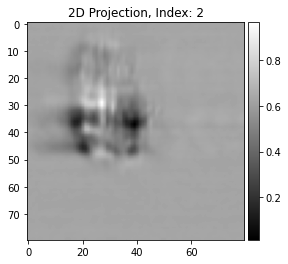

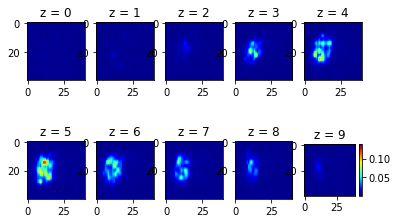

In [16]:
ImgIdx = 2
[ImgTensor2d,ImgTensor3d,ImgLabel] = image_datasets['train'].__getitem__(ImgIdx)
image2d = np.transpose(ImgTensor2d.numpy(), (1,2,0))
image3d = np.transpose(np.squeeze(ImgTensor3d.numpy()), (1,2,0))
DisplayImage(image2d,image2d.min(),image2d.max(),ImgIdx)
DisplayImage(image3d,image3d.min(),image3d.max(),ImgIdx)

In [17]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 2
# Batch size for training (change depending on how much memory you have)
batch_size = 64
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}
# dataloaders_dict = {}
# dataloaders_dict ['train'] = torch.utils.data.DataLoader(image_datasets['train'],batch_size=batch_size, num_workers=0, sampler=weighted_sampler)
# dataloaders_dict ['val'] = torch.utils.data.DataLoader(image_datasets['val'],batch_size=batch_size, shuffle=True, num_workers=0)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 3 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                               | 0/50 [00:00<?, ?it/s]



----------
Epoch 0/49
LR 1e-05
[[3697. 3803.]
 [2127. 5373.]]
train: CE: 0.658738, MSE: 0.123320, loss: 0.605196
train Acc: 0.6047
train Bal. Acc: 0.6047


num_epochs:   2%|█▎                                                                  | 1/50 [07:36<6:12:26, 456.05s/it]

[[1554.  946.]
 [ 733. 1767.]]
val: CE: 0.617001, MSE: 0.110139, loss: 0.566315
val Acc: 0.6642
val Bal. Acc: 0.6642
saving best model
Total time: 0:07:36.067693
Epoch time: 7m 36s


----------
Epoch 1/49
LR 1e-05
[[4957. 2543.]
 [2015. 5485.]]
train: CE: 0.573049, MSE: 0.065597, loss: 0.522304
train Acc: 0.6961
train Bal. Acc: 0.6961


num_epochs:   4%|██▋                                                                 | 2/50 [14:16<5:38:49, 423.54s/it]

[[2411.   89.]
 [1991.  509.]]
val: CE: 0.790326, MSE: 0.010833, loss: 0.712377
val Acc: 0.5840
val Bal. Acc: 0.5840
Total time: 0:14:16.851403
Epoch time: 6m 41s


----------
Epoch 2/49
LR 1e-05
[[5605. 1895.]
 [1249. 6251.]]
train: CE: 0.449794, MSE: 0.008408, loss: 0.405655
train Acc: 0.7904
train Bal. Acc: 0.7904


num_epochs:   6%|████                                                                | 3/50 [21:03<5:25:53, 416.03s/it]

[[2393.  107.]
 [1240. 1260.]]
val: CE: 0.604408, MSE: 0.007977, loss: 0.544765
val Acc: 0.7306
val Bal. Acc: 0.7306
saving best model
Total time: 0:21:03.944867
Epoch time: 6m 47s


----------
Epoch 3/49
LR 1e-05
[[6312. 1188.]
 [1048. 6452.]]
train: CE: 0.341939, MSE: 0.006963, loss: 0.308441
train Acc: 0.8509
train Bal. Acc: 0.8509


num_epochs:   8%|█████▍                                                              | 4/50 [27:58<5:18:31, 415.46s/it]

[[2445.   55.]
 [1199. 1301.]]
val: CE: 0.559626, MSE: 0.006162, loss: 0.504280
val Acc: 0.7492
val Bal. Acc: 0.7492
saving best model
Total time: 0:27:58.528227
Epoch time: 6m 55s


----------
Epoch 4/49
LR 1e-05
[[6655.  845.]
 [ 919. 6581.]]
train: CE: 0.282032, MSE: 0.004304, loss: 0.254259
train Acc: 0.8824
train Bal. Acc: 0.8824


num_epochs:  10%|██████▊                                                             | 5/50 [35:05<5:14:40, 419.57s/it]

[[2267.  233.]
 [ 393. 2107.]]
val: CE: 0.309952, MSE: 0.003071, loss: 0.279264
val Acc: 0.8748
val Bal. Acc: 0.8748
saving best model
Total time: 0:35:05.379982
Epoch time: 7m 7s


----------
Epoch 5/49
LR 5e-05
[[6752.  748.]
 [1031. 6469.]]
train: CE: 0.276302, MSE: 0.004099, loss: 0.249082
train Acc: 0.8814
train Bal. Acc: 0.8814


num_epochs:  12%|████████▏                                                           | 6/50 [41:37<5:00:45, 410.12s/it]

[[2495.    5.]
 [1865.  635.]]
val: CE: 0.825546, MSE: 0.003355, loss: 0.743327
val Acc: 0.6260
val Bal. Acc: 0.6260
Total time: 0:41:37.173541
Epoch time: 6m 32s


----------
Epoch 6/49
LR 5e-05
[[6908.  592.]
 [ 712. 6788.]]
train: CE: 0.205953, MSE: 0.002490, loss: 0.185607
train Acc: 0.9131
train Bal. Acc: 0.9131


num_epochs:  14%|█████████▌                                                          | 7/50 [48:07<4:49:14, 403.58s/it]

[[1220. 1280.]
 [  51. 2449.]]
val: CE: 0.587134, MSE: 0.002711, loss: 0.528692
val Acc: 0.7338
val Bal. Acc: 0.7338
Total time: 0:48:07.288035
Epoch time: 6m 30s


----------
Epoch 7/49
LR 5e-05
[[7054.  446.]
 [ 544. 6956.]]
train: CE: 0.167437, MSE: 0.002127, loss: 0.150906
train Acc: 0.9340
train Bal. Acc: 0.9340


num_epochs:  16%|██████████▉                                                         | 8/50 [54:36<4:39:18, 399.01s/it]

[[2089.  411.]
 [ 133. 2367.]]
val: CE: 0.265578, MSE: 0.001650, loss: 0.239185
val Acc: 0.8912
val Bal. Acc: 0.8912
saving best model
Total time: 0:54:36.504275
Epoch time: 6m 29s


----------
Epoch 8/49
LR 5e-05
[[7129.  371.]
 [ 438. 7062.]]
train: CE: 0.135284, MSE: 0.001237, loss: 0.121879
train Acc: 0.9461
train Bal. Acc: 0.9461


num_epochs:  18%|███████████▉                                                      | 9/50 [1:01:06<4:30:37, 396.04s/it]

[[2447.   53.]
 [ 716. 1784.]]
val: CE: 0.367582, MSE: 0.000971, loss: 0.330921
val Acc: 0.8462
val Bal. Acc: 0.8462
Total time: 1:01:06.024882
Epoch time: 6m 30s


----------
Epoch 9/49
LR 5e-05
[[7193.  307.]
 [ 378. 7122.]]
train: CE: 0.109129, MSE: 0.000876, loss: 0.098304
train Acc: 0.9543
train Bal. Acc: 0.9543


num_epochs:  20%|█████████████                                                    | 10/50 [1:07:35<4:22:36, 393.91s/it]

[[1315. 1185.]
 [  29. 2471.]]
val: CE: 0.993034, MSE: 0.000846, loss: 0.893815
val Acc: 0.7572
val Bal. Acc: 0.7572
Total time: 1:07:35.167624
Epoch time: 6m 29s


----------
Epoch 10/49
LR 5e-05
[[7279.  221.]
 [ 239. 7261.]]
train: CE: 0.076766, MSE: 0.000696, loss: 0.069159
train Acc: 0.9693
train Bal. Acc: 0.9693


num_epochs:  22%|██████████████▎                                                  | 11/50 [1:14:03<4:14:59, 392.30s/it]

[[ 118. 2382.]
 [   0. 2500.]]
val: CE: 4.258320, MSE: 0.000624, loss: 3.832550
val Acc: 0.5236
val Bal. Acc: 0.5236
Total time: 1:14:03.820606
Epoch time: 6m 29s


----------
Epoch 11/49
LR 5e-05
[[7350.  150.]
 [ 195. 7305.]]
train: CE: 0.064047, MSE: 0.000589, loss: 0.057701
train Acc: 0.9770
train Bal. Acc: 0.9770


num_epochs:  24%|███████████████▌                                                 | 12/50 [1:20:32<4:07:46, 391.22s/it]

[[1396. 1104.]
 [  14. 2486.]]
val: CE: 1.327095, MSE: 0.000574, loss: 1.194443
val Acc: 0.7764
val Bal. Acc: 0.7764
Total time: 1:20:32.579470
Epoch time: 6m 29s


----------
Epoch 12/49
LR 5e-05
[[7329.  171.]
 [ 208. 7292.]]
train: CE: 0.063265, MSE: 0.000564, loss: 0.056995
train Acc: 0.9747
train Bal. Acc: 0.9747


num_epochs:  26%|████████████████▉                                                | 13/50 [1:27:00<4:00:38, 390.24s/it]

[[1.155e+03 1.345e+03]
 [2.000e+00 2.498e+03]]
val: CE: 1.236252, MSE: 0.000469, loss: 1.112674
val Acc: 0.7306
val Bal. Acc: 0.7306
Epoch     8: reducing learning rate of group 0 to 2.5000e-05.
Total time: 1:27:00.546435
Epoch time: 6m 28s


----------
Epoch 13/49
LR 2.5e-05
[[7389.  111.]
 [ 121. 7379.]]
train: CE: 0.041568, MSE: 0.000476, loss: 0.037459
train Acc: 0.9845
train Bal. Acc: 0.9845


num_epochs:  28%|██████████████████▏                                              | 14/50 [1:33:28<3:53:46, 389.64s/it]

[[2358.  142.]
 [ 228. 2272.]]
val: CE: 0.248980, MSE: 0.000462, loss: 0.224128
val Acc: 0.9260
val Bal. Acc: 0.9260
saving best model
Total time: 1:33:28.788704
Epoch time: 6m 28s


----------
Epoch 14/49
LR 2.5e-05
[[7428.   72.]
 [  89. 7411.]]
train: CE: 0.028623, MSE: 0.000458, loss: 0.025807
train Acc: 0.9893
train Bal. Acc: 0.9893


num_epochs:  30%|███████████████████▌                                             | 15/50 [1:39:56<3:46:56, 389.04s/it]

[[2471.   29.]
 [ 594. 1906.]]
val: CE: 0.548868, MSE: 0.000442, loss: 0.494025
val Acc: 0.8754
val Bal. Acc: 0.8754
Total time: 1:39:56.466110
Epoch time: 6m 28s


----------
Epoch 15/49
LR 2.5e-05
[[7448.   52.]
 [  49. 7451.]]
train: CE: 0.020273, MSE: 0.000423, loss: 0.018288
train Acc: 0.9933
train Bal. Acc: 0.9933


num_epochs:  32%|████████████████████▊                                            | 16/50 [1:46:24<3:40:20, 388.83s/it]

[[2358.  142.]
 [ 200. 2300.]]
val: CE: 0.227506, MSE: 0.000401, loss: 0.204796
val Acc: 0.9316
val Bal. Acc: 0.9316
saving best model
Total time: 1:46:24.787333
Epoch time: 6m 28s


----------
Epoch 16/49
LR 2.5e-05
[[7469.   31.]
 [  37. 7463.]]
train: CE: 0.015192, MSE: 0.000396, loss: 0.013712
train Acc: 0.9955
train Bal. Acc: 0.9955


num_epochs:  34%|██████████████████████                                           | 17/50 [1:52:52<3:33:40, 388.50s/it]

[[2313.  187.]
 [ 144. 2356.]]
val: CE: 0.257941, MSE: 0.000397, loss: 0.232186
val Acc: 0.9338
val Bal. Acc: 0.9338
saving best model
Total time: 1:52:52.528485
Epoch time: 6m 28s


----------
Epoch 17/49
LR 2.5e-05
[[7471.   29.]
 [  20. 7480.]]
train: CE: 0.011170, MSE: 0.000378, loss: 0.010091
train Acc: 0.9967
train Bal. Acc: 0.9967


num_epochs:  36%|███████████████████████▍                                         | 18/50 [1:59:20<3:27:06, 388.32s/it]

[[2346.  154.]
 [ 202. 2298.]]
val: CE: 0.292064, MSE: 0.000370, loss: 0.262895
val Acc: 0.9288
val Bal. Acc: 0.9288
Total time: 1:59:20.418949
Epoch time: 6m 28s


----------
Epoch 18/49
LR 2.5e-05
[[7480.   20.]
 [  32. 7468.]]
train: CE: 0.011357, MSE: 0.000369, loss: 0.010258
train Acc: 0.9965
train Bal. Acc: 0.9965


num_epochs:  38%|████████████████████████▋                                        | 19/50 [2:05:48<3:20:34, 388.21s/it]

[[2315.  185.]
 [ 172. 2328.]]
val: CE: 0.274578, MSE: 0.000356, loss: 0.247156
val Acc: 0.9286
val Bal. Acc: 0.9286
Total time: 2:05:48.377343
Epoch time: 6m 28s


----------
Epoch 19/49
LR 2.5e-05
[[7467.   33.]
 [  33. 7467.]]
train: CE: 0.011769, MSE: 0.000358, loss: 0.010628
train Acc: 0.9956
train Bal. Acc: 0.9956


num_epochs:  40%|██████████████████████████                                       | 20/50 [2:12:16<3:14:09, 388.32s/it]

[[2388.  112.]
 [ 269. 2231.]]
val: CE: 0.338387, MSE: 0.000376, loss: 0.304586
val Acc: 0.9238
val Bal. Acc: 0.9238
Total time: 2:12:16.956909
Epoch time: 6m 29s


----------
Epoch 20/49
LR 2.5e-05
[[7476.   24.]
 [  33. 7467.]]
train: CE: 0.010928, MSE: 0.000351, loss: 0.009870
train Acc: 0.9962
train Bal. Acc: 0.9962


num_epochs:  42%|███████████████████████████▎                                     | 21/50 [2:18:45<3:07:41, 388.33s/it]

[[2444.   56.]
 [ 415. 2085.]]
val: CE: 0.455461, MSE: 0.000334, loss: 0.409948
val Acc: 0.9058
val Bal. Acc: 0.9058
Epoch    16: reducing learning rate of group 0 to 1.2500e-05.
Total time: 2:18:45.298977
Epoch time: 6m 28s


----------
Epoch 21/49
LR 1.25e-05
[[7481.   19.]
 [   9. 7491.]]
train: CE: 0.006132, MSE: 0.000334, loss: 0.005552
train Acc: 0.9981
train Bal. Acc: 0.9981


num_epochs:  44%|████████████████████████████▌                                    | 22/50 [2:25:13<3:01:12, 388.29s/it]

[[2276.  224.]
 [ 119. 2381.]]
val: CE: 0.289000, MSE: 0.000326, loss: 0.260133
val Acc: 0.9314
val Bal. Acc: 0.9314
Total time: 2:25:13.494696
Epoch time: 6m 28s


----------
Epoch 22/49
LR 1.25e-05
[[7483.   17.]
 [  21. 7479.]]
train: CE: 0.007790, MSE: 0.000328, loss: 0.007044
train Acc: 0.9975
train Bal. Acc: 0.9975


num_epochs:  46%|█████████████████████████████▉                                   | 23/50 [2:31:41<2:54:39, 388.14s/it]

[[2449.   51.]
 [ 386. 2114.]]
val: CE: 0.457669, MSE: 0.000321, loss: 0.411934
val Acc: 0.9126
val Bal. Acc: 0.9126
Total time: 2:31:41.279898
Epoch time: 6m 28s


----------
Epoch 23/49
LR 1.25e-05
[[7486.   14.]
 [   9. 7491.]]
train: CE: 0.005004, MSE: 0.000326, loss: 0.004536
train Acc: 0.9985
train Bal. Acc: 0.9985


num_epochs:  48%|███████████████████████████████▏                                 | 24/50 [2:38:09<2:48:11, 388.13s/it]

[[2407.   93.]
 [ 272. 2228.]]
val: CE: 0.346762, MSE: 0.000319, loss: 0.312118
val Acc: 0.9270
val Bal. Acc: 0.9270
Total time: 2:38:09.386954
Epoch time: 6m 28s


----------
Epoch 24/49
LR 1.25e-05
[[7.496e+03 4.000e+00]
 [9.000e+00 7.491e+03]]
train: CE: 0.003063, MSE: 0.000318, loss: 0.002789
train Acc: 0.9991
train Bal. Acc: 0.9991


num_epochs:  50%|████████████████████████████████▌                                | 25/50 [2:44:41<2:42:15, 389.44s/it]

[[2369.  131.]
 [ 188. 2312.]]
val: CE: 0.288469, MSE: 0.000311, loss: 0.259653
val Acc: 0.9362
val Bal. Acc: 0.9362
saving best model
Total time: 2:44:41.873646
Epoch time: 6m 32s


----------
Epoch 25/49
LR 1.25e-05
[[7.496e+03 4.000e+00]
 [7.000e+00 7.493e+03]]
train: CE: 0.002396, MSE: 0.000313, loss: 0.002188
train Acc: 0.9993
train Bal. Acc: 0.9993


num_epochs:  52%|█████████████████████████████████▊                               | 26/50 [2:51:25<2:37:29, 393.74s/it]

[[2372.  128.]
 [ 213. 2287.]]
val: CE: 0.316067, MSE: 0.000305, loss: 0.284491
val Acc: 0.9318
val Bal. Acc: 0.9318
Total time: 2:51:25.651450
Epoch time: 6m 44s


----------
Epoch 26/49
LR 1.25e-05
[[7.496e+03 4.000e+00]
 [5.000e+00 7.495e+03]]
train: CE: 0.002592, MSE: 0.000308, loss: 0.002363
train Acc: 0.9994
train Bal. Acc: 0.9994


num_epochs:  54%|███████████████████████████████████                              | 27/50 [2:58:13<2:32:31, 397.90s/it]

[[2422.   78.]
 [ 276. 2224.]]
val: CE: 0.331840, MSE: 0.000301, loss: 0.298686
val Acc: 0.9292
val Bal. Acc: 0.9292
Total time: 2:58:13.264279
Epoch time: 6m 48s


----------
Epoch 27/49
LR 1.25e-05
[[7.500e+03 0.000e+00]
 [3.000e+00 7.497e+03]]
train: CE: 0.001284, MSE: 0.000303, loss: 0.001186
train Acc: 0.9998
train Bal. Acc: 0.9998


num_epochs:  56%|████████████████████████████████████▍                            | 28/50 [3:05:02<2:27:09, 401.35s/it]

[[2391.  109.]
 [ 215. 2285.]]
val: CE: 0.285634, MSE: 0.000296, loss: 0.257100
val Acc: 0.9352
val Bal. Acc: 0.9352
Epoch    23: reducing learning rate of group 0 to 6.2500e-06.
Total time: 3:05:02.654889
Epoch time: 6m 49s


----------
Epoch 28/49
LR 6.25e-06
[[7.498e+03 2.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.001203, MSE: 0.000300, loss: 0.001112
train Acc: 0.9997
train Bal. Acc: 0.9997


num_epochs:  58%|█████████████████████████████████████▋                           | 29/50 [3:11:53<2:21:28, 404.21s/it]

[[2410.   90.]
 [ 230. 2270.]]
val: CE: 0.299864, MSE: 0.000294, loss: 0.269907
val Acc: 0.9360
val Bal. Acc: 0.9360
Total time: 3:11:53.553848
Epoch time: 6m 51s


----------
Epoch 29/49
LR 6.25e-06
[[7.500e+03 0.000e+00]
 [3.000e+00 7.497e+03]]
train: CE: 0.001144, MSE: 0.000298, loss: 0.001060
train Acc: 0.9998
train Bal. Acc: 0.9998


num_epochs:  60%|███████████████████████████████████████                          | 30/50 [3:18:46<2:15:36, 406.85s/it]

[[2354.  146.]
 [ 169. 2331.]]
val: CE: 0.280363, MSE: 0.000292, loss: 0.252356
val Acc: 0.9370
val Bal. Acc: 0.9370
saving best model
Total time: 3:18:46.554686
Epoch time: 6m 53s


----------
Epoch 30/49
LR 6.25e-06
[[7.498e+03 2.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000982, MSE: 0.000296, loss: 0.000914
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  62%|████████████████████████████████████████▎                        | 31/50 [3:25:31<2:08:40, 406.36s/it]

[[2424.   76.]
 [ 262. 2238.]]
val: CE: 0.329119, MSE: 0.000289, loss: 0.296236
val Acc: 0.9324
val Bal. Acc: 0.9324
Total time: 3:25:31.786493
Epoch time: 6m 45s


----------
Epoch 31/49
LR 6.25e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000876, MSE: 0.000293, loss: 0.000818
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  64%|█████████████████████████████████████████▌                       | 32/50 [3:32:30<2:02:59, 409.99s/it]

[[2387.  113.]
 [ 204. 2296.]]
val: CE: 0.282536, MSE: 0.000287, loss: 0.254312
val Acc: 0.9366
val Bal. Acc: 0.9366
Total time: 3:32:30.232110
Epoch time: 6m 58s


----------
Epoch 32/49
LR 6.25e-06
[[7.500e+03 0.000e+00]
 [2.000e+00 7.498e+03]]
train: CE: 0.000807, MSE: 0.000291, loss: 0.000755
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  66%|██████████████████████████████████████████▉                      | 33/50 [3:39:20<1:56:12, 410.13s/it]

[[2402.   98.]
 [ 226. 2274.]]
val: CE: 0.310666, MSE: 0.000285, loss: 0.279628
val Acc: 0.9352
val Bal. Acc: 0.9352
Total time: 3:39:20.689696
Epoch time: 6m 50s


----------
Epoch 33/49
LR 6.25e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000735, MSE: 0.000289, loss: 0.000690
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  68%|████████████████████████████████████████████▏                    | 34/50 [3:46:06<1:49:00, 408.81s/it]

[[2404.   96.]
 [ 237. 2263.]]
val: CE: 0.307007, MSE: 0.000282, loss: 0.276334
val Acc: 0.9334
val Bal. Acc: 0.9334
Total time: 3:46:06.417460
Epoch time: 6m 46s


----------
Epoch 34/49
LR 6.25e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000549, MSE: 0.000287, loss: 0.000523
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  70%|█████████████████████████████████████████████▌                   | 35/50 [3:52:50<1:41:52, 407.53s/it]

[[2419.   81.]
 [ 260. 2240.]]
val: CE: 0.322189, MSE: 0.000280, loss: 0.289998
val Acc: 0.9318
val Bal. Acc: 0.9318
Epoch    30: reducing learning rate of group 0 to 3.1250e-06.
Total time: 3:52:50.952987
Epoch time: 6m 45s


----------
Epoch 35/49
LR 3.125e-06
[[7.498e+03 2.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000649, MSE: 0.000285, loss: 0.000613
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  72%|██████████████████████████████████████████████▊                  | 36/50 [3:59:33<1:34:45, 406.11s/it]

[[2401.   99.]
 [ 221. 2279.]]
val: CE: 0.308578, MSE: 0.000279, loss: 0.277748
val Acc: 0.9360
val Bal. Acc: 0.9360
Total time: 3:59:33.745595
Epoch time: 6m 43s


----------
Epoch 36/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000861, MSE: 0.000284, loss: 0.000803
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  74%|████████████████████████████████████████████████                 | 37/50 [4:06:27<1:28:29, 408.42s/it]

[[2421.   79.]
 [ 252. 2248.]]
val: CE: 0.323940, MSE: 0.000278, loss: 0.291573
val Acc: 0.9338
val Bal. Acc: 0.9338
Total time: 4:06:27.551369
Epoch time: 6m 54s


----------
Epoch 37/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000663, MSE: 0.000283, loss: 0.000625
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  76%|█████████████████████████████████████████████████▍               | 38/50 [4:13:09<1:21:18, 406.53s/it]

[[2413.   87.]
 [ 239. 2261.]]
val: CE: 0.315528, MSE: 0.000277, loss: 0.284003
val Acc: 0.9348
val Bal. Acc: 0.9348
Total time: 4:13:09.671684
Epoch time: 6m 42s


----------
Epoch 38/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000773, MSE: 0.000282, loss: 0.000724
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  78%|██████████████████████████████████████████████████▋              | 39/50 [4:19:51<1:14:17, 405.20s/it]

[[2406.   94.]
 [ 230. 2270.]]
val: CE: 0.308587, MSE: 0.000276, loss: 0.277756
val Acc: 0.9352
val Bal. Acc: 0.9352
Total time: 4:19:51.769316
Epoch time: 6m 42s


----------
Epoch 39/49
LR 3.125e-06
[[7.499e+03 1.000e+00]
 [3.000e+00 7.497e+03]]
train: CE: 0.001518, MSE: 0.000281, loss: 0.001394
train Acc: 0.9997
train Bal. Acc: 0.9997


num_epochs:  80%|████████████████████████████████████████████████████             | 40/50 [4:26:32<1:07:17, 403.80s/it]

[[2415.   85.]
 [ 248. 2252.]]
val: CE: 0.330665, MSE: 0.000275, loss: 0.297626
val Acc: 0.9334
val Bal. Acc: 0.9334
Total time: 4:26:32.297259
Epoch time: 6m 41s


----------
Epoch 40/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000875, MSE: 0.000280, loss: 0.000815
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  82%|█████████████████████████████████████████████████████▎           | 41/50 [4:33:24<1:00:55, 406.21s/it]

[[2430.   70.]
 [ 291. 2209.]]
val: CE: 0.341850, MSE: 0.000274, loss: 0.307693
val Acc: 0.9278
val Bal. Acc: 0.9278
Total time: 4:33:24.149200
Epoch time: 6m 52s


----------
Epoch 41/49
LR 3.125e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000535, MSE: 0.000279, loss: 0.000510
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  84%|████████████████████████████████████████████████████████▎          | 42/50 [4:40:18<54:29, 408.74s/it]

[[2402.   98.]
 [ 226. 2274.]]
val: CE: 0.310489, MSE: 0.000273, loss: 0.279467
val Acc: 0.9352
val Bal. Acc: 0.9352
Epoch    37: reducing learning rate of group 0 to 1.5625e-06.
Total time: 4:40:18.774915
Epoch time: 6m 55s


----------
Epoch 42/49
LR 1.5625e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000730, MSE: 0.000278, loss: 0.000685
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  86%|█████████████████████████████████████████████████████████▌         | 43/50 [4:47:04<47:34, 407.74s/it]

[[2410.   90.]
 [ 235. 2265.]]
val: CE: 0.319668, MSE: 0.000272, loss: 0.287728
val Acc: 0.9350
val Bal. Acc: 0.9350
Total time: 4:47:04.172013
Epoch time: 6m 45s


----------
Epoch 43/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000634, MSE: 0.000277, loss: 0.000598
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  88%|██████████████████████████████████████████████████████████▉        | 44/50 [4:53:44<40:33, 405.61s/it]

[[2386.  114.]
 [ 200. 2300.]]
val: CE: 0.295394, MSE: 0.000271, loss: 0.265882
val Acc: 0.9372
val Bal. Acc: 0.9372
saving best model
Total time: 4:53:44.811362
Epoch time: 6m 41s


----------
Epoch 44/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000572, MSE: 0.000277, loss: 0.000542
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  90%|████████████████████████████████████████████████████████████▎      | 45/50 [5:00:29<33:47, 405.42s/it]

[[2423.   77.]
 [ 247. 2253.]]
val: CE: 0.330295, MSE: 0.000271, loss: 0.297292
val Acc: 0.9352
val Bal. Acc: 0.9352
Total time: 5:00:29.793826
Epoch time: 6m 45s


----------
Epoch 45/49
LR 1.5625e-06
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000587, MSE: 0.000276, loss: 0.000556
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs:  92%|█████████████████████████████████████████████████████████████▋     | 46/50 [5:07:10<26:56, 404.12s/it]

[[2378.  122.]
 [ 197. 2303.]]
val: CE: 0.289073, MSE: 0.000270, loss: 0.260193
val Acc: 0.9362
val Bal. Acc: 0.9362
Total time: 5:07:10.876929
Epoch time: 6m 41s


----------
Epoch 46/49
LR 1.5625e-06
[[7.499e+03 1.000e+00]
 [0.000e+00 7.500e+03]]
train: CE: 0.000740, MSE: 0.000276, loss: 0.000694
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  94%|██████████████████████████████████████████████████████████████▉    | 47/50 [5:13:39<19:58, 399.53s/it]

[[2386.  114.]
 [ 202. 2298.]]
val: CE: 0.300273, MSE: 0.000270, loss: 0.270272
val Acc: 0.9368
val Bal. Acc: 0.9368
Total time: 5:13:39.702094
Epoch time: 6m 29s


----------
Epoch 47/49
LR 1.5625e-06
[[7.500e+03 0.000e+00]
 [3.000e+00 7.497e+03]]
train: CE: 0.000893, MSE: 0.000275, loss: 0.000831
train Acc: 0.9998
train Bal. Acc: 0.9998


num_epochs:  96%|████████████████████████████████████████████████████████████████▎  | 48/50 [5:20:04<13:10, 395.26s/it]

[[2377.  123.]
 [ 194. 2306.]]
val: CE: 0.288521, MSE: 0.000269, loss: 0.259696
val Acc: 0.9366
val Bal. Acc: 0.9366
Total time: 5:20:04.997913
Epoch time: 6m 25s


----------
Epoch 48/49
LR 1.5625e-06
[[7.500e+03 0.000e+00]
 [1.000e+00 7.499e+03]]
train: CE: 0.000481, MSE: 0.000275, loss: 0.000460
train Acc: 0.9999
train Bal. Acc: 0.9999


num_epochs:  98%|█████████████████████████████████████████████████████████████████▋ | 49/50 [5:26:30<06:32, 392.21s/it]

[[2418.   82.]
 [ 256. 2244.]]
val: CE: 0.327901, MSE: 0.000269, loss: 0.295138
val Acc: 0.9324
val Bal. Acc: 0.9324
Epoch    44: reducing learning rate of group 0 to 7.8125e-07.
Total time: 5:26:30.078725
Epoch time: 6m 25s


----------
Epoch 49/49
LR 7.8125e-07
[[7500.    0.]
 [   0. 7500.]]
train: CE: 0.000722, MSE: 0.000274, loss: 0.000677
train Acc: 1.0000
train Bal. Acc: 1.0000


num_epochs: 100%|███████████████████████████████████████████████████████████████████| 50/50 [5:32:54<00:00, 399.50s/it]

[[2394.  106.]
 [ 218. 2282.]]
val: CE: 0.303149, MSE: 0.000268, loss: 0.272861
val Acc: 0.9352
val Bal. Acc: 0.9352
Total time: 5:32:54.928652
Epoch time: 6m 25s
Best val loss: 0.265882
Best val acc: 0.937200
50


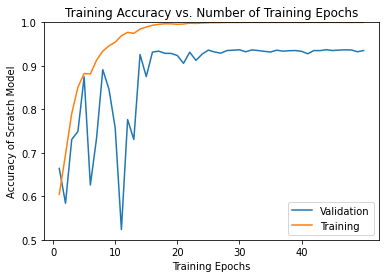

50


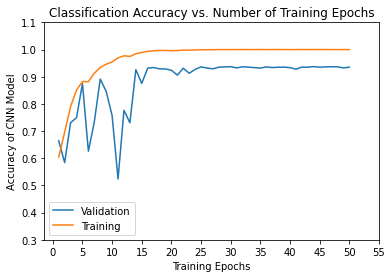

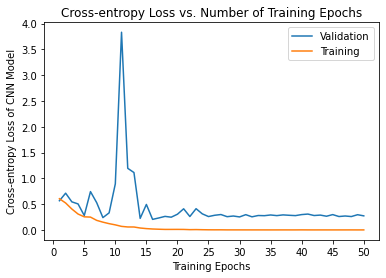

tensor([[2386.,  114.],
        [ 200., 2300.]])
[2586. 2414.]
[[0.9544 0.0456]
 [0.08   0.92  ]]





In [18]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (3,4):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
#     trainpath =[X[i] for i in trainindex[runs]]
#     testpath =[X[i] for i in testindex[runs]]
    
    trainpath2d =[X2d[i] for i in trainindex2d[runs]]
    trainpath3d =[X3d[i] for i in trainindex3d[runs]]
    testpath2d =[X2d[i] for i in testindex2d[runs]]
    testpath3d =[X3d[i] for i in testindex3d[runs]]
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath2d,trainpath3d)
    image_datasets['val'] = MyDataset(testpath2d,testpath3d)
    
#     ImgIdx = 4
#     [ImgTensor2d,ImgTensor3d,ImgLabel] = image_datasets['train'].__getitem__(ImgIdx)
#     image2d = np.transpose(ImgTensor2d.numpy(), (1,2,0))
#     image3d = np.transpose(np.squeeze(ImgTensor3d.numpy()), (1,2,0))
#     DisplayImage(image2d,image2d.min(),image3d.max(),ImgIdx)
#     DisplayImage(image3d,image3d.min(),image3d.max(),ImgIdx)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 2
    in_channel = 1
    num_epochs = 50
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        model = UNet2D3D(num_class, in_channel)
        model.apply(init_weights)
#         model.half() 
        model
        model = model.to(device)
#         model = model.half()
        # freeze backbone layers
        # Comment out to finetune further
        # for l in model.base_layers:
        #     for param in l.parameters():
        #         param.requires_grad = False

        optimizer_ft1 = optim.Adam(model.parameters(), lr=1e-5,betas = (0.99, 0.9999),eps=1e-08,weight_decay=0)
        optimizer_ft2 = optim.Adam(model.parameters(),lr=5e-5,betas = (0.99, 0.9999),eps=1e-08,weight_decay=0)
        # optimizer_ft1 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # optimizer_ft2 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) 
        exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=4, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-7, eps=1e-08)
        exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=4, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-7, eps=1e-08)       
        model, scratch_hist_train,loss_hist_train,scratch_hist_val, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(model, dataloaders_dict,optimizer_ft1, optimizer_ft2, exp_lr_scheduler1,exp_lr_scheduler2, num_epochs)
        if len(loss_hist_train)<num_epochs:
            print('model diverges, reinitializing training....\n')
            print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        
    # num_epochs=15
    shistVal = [h.cpu().numpy() for h in scratch_hist_val]
    shistTrain= [h.cpu().numpy() for h in scratch_hist_train]
    # shistBaccTrain= [h.cpu().numpy() for h in train_Bacc_hist]
    # shistBaccVal= [h.cpu().numpy() for h in val_Bacc_hist]
    # shistLossTrain= [h.cpu().numpy() for h in loss_hist_train]
    # shistLossVal= [h.cpu().numpy() for h in loss_hist_val]
    # shistLR= [h.cpu().numpy() for h in lr_hist]
    fname1 = "training_acc_"+str(runs)+".csv"
    np.savetxt(fname1,shistTrain, delimiter=",")
    fname2 = "validation_acc_"+str(runs)+".csv"
    np.savetxt(fname2,shistVal , delimiter=",")
    fname13 = "training_Bacc_"+str(runs)+".csv"
    np.savetxt(fname13,train_Bacc_hist, delimiter=",")
    fname23 = "validation_Bacc_"+str(runs)+".csv"
    np.savetxt(fname23,val_Bacc_hist, delimiter=",")
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist, delimiter=",")

    shist = []
    shist1 = []

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Training Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of Scratch Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.5,1.))
    plt.xticks(np.arange(0, num_epochs, 10.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'.png'
    plt.savefig(fname3)
    plt.show()

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Classification Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of CNN Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.3,1.1))
    plt.xticks(np.arange(0, len(shist)+10, 5.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
    plt.savefig(fname3)
    plt.show()

    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Cross-entropy Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Cross-entropy Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs2d, inputs3d, classes) in enumerate(dataloaders_dict['val']):
            inputs2d = inputs2d.type(torch.FloatTensor)
            inputs2d = inputs2d.to(device)
            inputs3d = inputs3d.type(torch.FloatTensor)
            inputs3d = inputs3d.to(device)
            classes = classes.to(device)
            _,_, outputs = model(inputs2d, inputs3d)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    confusionMat = np.asarray(confusion_matrix)
    sumconfusion = np.sum(confusionMat,axis = 0)
    print(sumconfusion)

    import scipy
    sumconfusion = np.sum(confusionMat,axis = 1).T
    # print(np.tile(sumconfusion,(4,1)))
    summat = np.tile(sumconfusion,(2,1)).T
    # print(test)
    percentconfusion = np.divide(confusionMat,summat)
    print(percentconfusion)
    fname4 = "UNet_LiverEndothelial_confusionMat_"+str(runs)+".csv"
    np.savetxt(fname4,confusionMat , delimiter=",")
    fname5 = "UNet_LiverEndothelial_confusionPer_"+str(runs)+".csv"
    np.savetxt(fname5,percentconfusion , delimiter=",")
    fname6 = 'UNet_LiverEndothelial_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')

In [ ]:
runs = 1
shistVal = [h.cpu().numpy() for h in scratch_hist_val]
shistTrain= [h.cpu().numpy() for h in scratch_hist_train]
# shistBaccTrain= [h.cpu().numpy() for h in train_Bacc_hist]
# shistBaccVal= [h.cpu().numpy() for h in val_Bacc_hist]
# shistLossTrain= [h.cpu().numpy() for h in loss_hist_train]
# shistLossVal= [h.cpu().numpy() for h in loss_hist_val]
# shistLR= [h.cpu().numpy() for h in lr_hist]
fname1 = "training_acc_"+str(runs)+".csv"
np.savetxt(fname1,shistTrain, delimiter=",")
fname2 = "validation_acc_"+str(runs)+".csv"
np.savetxt(fname2,shistVal , delimiter=",")
fname13 = "training_Bacc_"+str(runs)+".csv"
np.savetxt(fname13,train_Bacc_hist, delimiter=",")
fname23 = "validation_Bacc_"+str(runs)+".csv"
np.savetxt(fname23,val_Bacc_hist, delimiter=",")
fname20 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname20,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")
fname22 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname22,lr_hist, delimiter=",")

shist = []
shist1 = []

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of Scratch Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Classification Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of CNN Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.3,1.1))
plt.xticks(np.arange(0, len(shist)+10, 5.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
plt.savefig(fname3)
plt.show()

train_loss = [h for h in loss_hist_train]
val_loss = [h for h in loss_hist_val]
plt.title("Cross-entropy Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Cross-entropy Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname31 = 'loss_curve_'+str(runs)+'.png'
plt.savefig(fname31)
plt.show()

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs2d, inputs3d, classes) in enumerate(dataloaders_dict['val']):
        inputs2d = inputs2d.type(torch.FloatTensor)
        inputs2d = inputs2d.to(device)
        inputs3d = inputs3d.type(torch.FloatTensor)
        inputs3d = inputs3d.to(device)
        classes = classes.to(device)
        _,_, outputs = model(inputs2d, inputs3d)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(2,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "UNet_LiverStellate_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "UNet_LiverStellate_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'UNet_LiverStellate_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)

In [ ]:
import pandas as pd

df = pd.read_csv (r'./UNet_LiverEndothelial_confusionPer_0.csv',header=None)
ConfuMat0 = df.to_numpy()
df = pd.read_csv (r'./UNet_LiverEndothelial_confusionPer_1.csv',header=None)
ConfuMat1 = df.to_numpy()
df = pd.read_csv (r'./UNet_LiverEndothelial_confusionPer_2.csv',header=None)
ConfuMat2 = df.to_numpy()
df = pd.read_csv (r'./UNet_LiverEndothelial_confusionPer_3.csv',header=None)
ConfuMat3 = df.to_numpy()

In [ ]:
GroupName = ['Healthy','Diseased']
categories = GroupName
make_confusion_matrix(ConfuMat0, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'Fused UNet - Endothelial Cell-Fold 0')
make_confusion_matrix(ConfuMat1, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'Fused UNet - Endothelial Cell-Fold 1')
make_confusion_matrix(ConfuMat2, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'Fused UNet - Endothelial Cell-Fold 2')
make_confusion_matrix(ConfuMat3, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'Fused UNet - Endothelial Cell-Fold 3')

In [ ]:
import pandas as pd

df = pd.read_csv (r'./training_loss_0.csv',header=None)
TrainLoss0 = df.to_numpy()
df = pd.read_csv (r'./training_loss_1.csv',header=None)
TrainLoss1 = df.to_numpy()
df = pd.read_csv (r'./training_loss_2.csv',header=None)
TrainLoss2 = df.to_numpy()
df = pd.read_csv (r'./training_loss_3.csv',header=None)
TrainLoss3 = df.to_numpy()
# df = pd.read_csv (r'./SuccessfulModelTraining1007/training_loss_4.csv',header=None)
# TrainLoss4 = df.to_numpy()

df = pd.read_csv (r'./validation_loss_0.csv',header=None)
ValLoss0 = df.to_numpy()
df = pd.read_csv (r'./validation_loss_1.csv',header=None)
ValLoss1 = df.to_numpy()
df = pd.read_csv (r'./validation_loss_2.csv',header=None)
ValLoss2 = df.to_numpy()
df = pd.read_csv (r'./validation_loss_3.csv',header=None)
ValLoss3 = df.to_numpy()
# df = pd.read_csv (r'./SuccessfulModelTraining1007/validation_loss_4.csv',header=None)
# ValLoss4 = df.to_numpy()

plt.figure()
plt.plot(TrainLoss0,label = 'Fold-0 (Train)', color='royalblue', linestyle = '--')
plt.plot(ValLoss0,label = 'Fold-0 (Validation)', color='darkblue', linestyle = '-')
plt.plot(TrainLoss1,label = 'Fold-1 (Train)', color='green', linestyle = '--')
plt.plot(ValLoss1,label = 'Fold-1 (Validation)', color='darkgreen', linestyle = '-')
plt.plot(TrainLoss2,label = 'Fold-2 (Train)', color='darkorange', linestyle = '--')
plt.plot(ValLoss2,label = 'Fold-2 (Validation)', color='goldenrod', linestyle = '-')
plt.plot(TrainLoss3,label = 'Fold-3 (Train)', color='orangered', linestyle = '--')
plt.plot(ValLoss3,label = 'Fold-3 (Validation)', color='maroon', linestyle = '-')
# plt.plot(TrainLoss4,label = 'Fold-4 (Train)', color='magenta', linestyle = '--')
# plt.plot(ValLoss4,label = 'Fold-4 (Validation)', color='purple', linestyle = '-')
plt.title('loss curves')
plt.xlabel('epochs')
plt.ylabel('weighted loss')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv (r'./training_Bacc_0.csv',header=None)
TrainLoss0 = df.to_numpy()
df = pd.read_csv (r'./training_Bacc_1.csv',header=None)
TrainLoss1 = df.to_numpy()
df = pd.read_csv (r'./training_Bacc_2.csv',header=None)
TrainLoss2 = df.to_numpy()
df = pd.read_csv (r'./training_Bacc_3.csv',header=None)
TrainLoss3 = df.to_numpy()
# df = pd.read_csv (r'./SuccessfulModelTraining1007/training_loss_4.csv',header=None)
# TrainLoss4 = df.to_numpy()

df = pd.read_csv (r'./validation_Bacc_0.csv',header=None)
ValLoss0 = df.to_numpy()
df = pd.read_csv (r'./validation_Bacc_1.csv',header=None)
ValLoss1 = df.to_numpy()
df = pd.read_csv (r'./validation_Bacc_2.csv',header=None)
ValLoss2 = df.to_numpy()
df = pd.read_csv (r'./validation_Bacc_3.csv',header=None)
ValLoss3 = df.to_numpy()
# df = pd.read_csv (r'./SuccessfulModelTraining1007/validation_loss_4.csv',header=None)
# ValLoss4 = df.to_numpy()

plt.figure()
plt.plot(TrainLoss0,label = 'Fold-0 (Train)', color='royalblue', linestyle = '--')
plt.plot(ValLoss0,label = 'Fold-0 (Validation)', color='darkblue', linestyle = '-')
plt.plot(TrainLoss1,label = 'Fold-1 (Train)', color='green', linestyle = '--')
plt.plot(ValLoss1,label = 'Fold-1 (Validation)', color='darkgreen', linestyle = '-')
plt.plot(TrainLoss2,label = 'Fold-2 (Train)', color='darkorange', linestyle = '--')
plt.plot(ValLoss2,label = 'Fold-2 (Validation)', color='goldenrod', linestyle = '-')
plt.plot(TrainLoss3,label = 'Fold-3 (Train)', color='orangered', linestyle = '--')
plt.plot(ValLoss3,label = 'Fold-3 (Validation)', color='maroon', linestyle = '-')
# plt.plot(TrainLoss4,label = 'Fold-4 (Train)', color='magenta', linestyle = '--')
# plt.plot(ValLoss4,label = 'Fold-4 (Validation)', color='purple', linestyle = '-')
plt.title('Balance accuracy curves')
plt.xlabel('epochs')
plt.ylabel('Balance accuracy')
plt.legend(bbox_to_anchor=(1.1, 0.7))
plt.show()

In [ ]:
df = pd.read_csv (r'./learning_rate_0.csv',header=None)
LearnRate0 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_1.csv',header=None)
LearnRate1 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_2.csv',header=None)
LearnRate2 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_3.csv',header=None)
LearnRate3 = df.to_numpy()
# df = pd.read_csv (r'./SuccessfulModelTraining1007/learning_rate_4.csv',header=None)
# LearnRate4 = df.to_numpy()

plt.figure()
plt.plot(LearnRate0,label = 'Fold-0', color='darkblue', linestyle = '-')
plt.plot(LearnRate1,label = 'Fold-1', color='darkgreen', linestyle = '-')
plt.plot(LearnRate2,label = 'Fold-2', color='goldenrod', linestyle = '-')
plt.plot(LearnRate3,label = 'Fold-3', color='maroon', linestyle = '-')
# plt.plot(LearnRate4,label = 'Fold-4', color='purple', linestyle = '-')
plt.title('learning rate curves')
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

In [ ]:
type(scratch_hist_train)

In [ ]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories, annot_kws={"size": 20})

    if xyplotlabels:
        plt.ylabel('True label',fontsize = 15)
        plt.xlabel('Predicted label' + stats_text,fontsize = 15)
    else:
        plt.xlabel(stats_text,fontsize = 15)
    
    if title:
        plt.title(title,fontsize = 15)

In [ ]:
categories = CellName
make_confusion_matrix(percentconfusion, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Greens',title = '3DCNN UNet - 3D Input')

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size(0),-1)

In [ ]:
class maxpool(nn.Module):
    def __init__(self):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool3d(2)
        
    def forward(self, x):
        x = self.maxpool(x)
        return x

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = torch.load('celltypemodel-unet_80rech_Run_1.pth.tar')
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:1]),maxpool(),*(list(scratch_model.children())[1:2]),maxpool(),*(list(scratch_model.children())[2:3]),maxpool(),*(list(scratch_model.children())[3:4]),maxpool(),*(list(scratch_model.children())[4:5]),maxpool(),Flatten(),*(list(scratch_model.children())[-5:-4]))
# scratch_model_fc = nn.Sequential(*list(scratch_model.children())[:-3])
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

In [ ]:
# list(scratch_model.children())

In [ ]:
#testing
image_datasets = {}
test_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(valpath)
image_datasets['val'].__getitem__(0)[0].shape

In [ ]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 64
# Create training and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs)
        outputs = outputs.cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [ ]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=40, learning_rate=200,early_exaggeration = 50, n_iter=2000)
X_2d = tsne.fit_transform(outputlist)
CellName = ['HEK-293','HeLa','MCF-7']


In [ ]:
target_ids = range(len(outputlist))
plt.figure()
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=3, c=c, label=label,alpha=0.5)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE plot')
plt.show()

In [ ]:
scratch_model = torch.load('celltypemodel-unet_80rech_Run_1.pth.tar')
scratch_model = scratch_model.to(device)
scratch_model.eval()

In [ ]:
CellName = ['Granulocyte','Lymphocyte','Monocyte']
ImgTensor, Label = image_datasets['val'].__getitem__(2)
image = np.squeeze(ImgTensor.numpy())
print('Ground Truth Cell Type: ', CellName[Label])
DisplayImage(image,image.min(),image.max())

In [ ]:
inputs = torch.unsqueeze(ImgTensor,0).to(device)
[output,prediction] = scratch_model(inputs)
# output = output.squeeze()
output = output.squeeze()
output = output.cpu().clone().detach().numpy()
_, preds = torch.max(prediction, 1)
preds = preds.cpu().clone().detach()

In [ ]:
# print(output/output.max())
print(output.max())
print(output.shape)
print('Predicted Cell Type: ', CellName[preds])
image = np.squeeze(output)
DisplayImage(image,image.min(),image.max())